### Importing libraries,packages and modules

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import RMSprop
from torch.optim import Adam
from torch.utils.data import WeightedRandomSampler
import shutil
import nibabel as nib
import skimage.transform as skTrans



In [2]:
!cp -r "../input/t1images/exactT1/exactT1"  "/kaggle/working/"
!cp  "../input/t1images/test.csv" "/kaggle/working/"
!cp  "../input/t1images/train.csv" "/kaggle/working/"

In [3]:
!pip install git+https://github.com/facebookresearch/fvcore.git

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-j3xha3wx
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-j3xha3wx
  Resolved https://github.com/facebookresearch/fvcore.git to commit 652b17de55ed7ed43979d0d8175b2804621a3bed
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 82.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for fvcore: filename=fvcore-0.1.5-py3-none-any.whl size=65365 sha256=58d69241a138eab0237568cb1721d003265e4f59d40a6aa29fb08a9c0111d680
  Stored in directory: /tmp/pip-ephem-wheel-cache-ti_8mvhf/wheels/24/1d/09/8167de727fe5b74f832b6fcb5d9069d8f03ca29f337bfe484d
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31549 sha256=f5a302cb273712e3371120b649a402c03cc92937643400657eba081e3e8a6b47
  Stored in directory: /root/.cache/pip/wheels/aa/cc/ed/ca4e88beef656b01c84

### Writing class for custom dataset and custom dataloader

In [4]:
class T1Dataset(Dataset):
    def __init__(self, csv_file, root_dir,transforms) :
        super().__init__()
        self.annotations = pd.read_csv(csv_file)
        self.root_dir    = root_dir
        self.transforms  = transforms
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
       
        img_path =  os.path.join(self.root_dir,self.annotations.iloc[index,0] + '_ceT1.nii')  
        
        img      =  nib.load(img_path).get_fdata()
       
        img = skTrans.resize(img, (200,200,15), order=1, preserve_range=True)
        img = img.astype(np.float64)
        img = torch.as_tensor(img).view(1,15,200,200)
        label    = int(self.annotations.iloc[index,3]) - 1
        if self.transforms:
            img = self.transforms(img)
        return (img.float(),label)

In [5]:
train_set = T1Dataset('./train.csv',root_dir='./exactT1/',transforms=None)

###  Function to build a model and choose desired optimizer,loss function,learning rate and number of layers to freeze

In [6]:
def build_model(loss_function,optimizer,learning_rate,freeze_layers):
    model = torch.hub.load('facebookresearch/pytorchvideo', 'slow_r50', pretrained=True)
    model.blocks[0].conv = nn.Conv3d(1, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    model.blocks[-1].output_pool = nn.Sequential(nn.AdaptiveAvgPool3d(output_size=1),
                                             nn.Flatten(),
                                             nn.Linear(400,100),
                                             nn.LeakyReLU(0.1),
                                             nn.Linear(100,16),
                                             nn.LeakyReLU(0.1),
                                             nn.Linear(16,4),
                                             nn.LogSoftmax(dim=1))
    if optimizer == 'Adam':
        optim = torch.optim.Adam(model.parameters(),lr=learning_rate)
    else:
        optim = torch.optim.RMSprop(model.parameters(),lr=learning_rate)
    if(loss_function == 'cross_entropy'):
        criterion = nn.CrossEntropyLoss()
    else:
        pass
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device=device)
    layers = 0
    for param in model.parameters():
        layers += 1
        param.requires_grad = False
        if layers == freeze_layers:
            break
    return model,optim,criterion

In [7]:
model,optimizer,criterion = build_model('cross_entropy','Adam',3e-4,10)
print(model)

Downloading: "https://github.com/facebookresearch/pytorchvideo/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/SLOW_8x8_R50.pyth" to /root/.cache/torch/hub/checkpoints/SLOW_8x8_R50.pyth


  0%|          | 0.00/248M [00:00<?, ?B/s]

Net(
  (blocks): ModuleList(
    (0): ResNetBasicStem(
      (conv): Conv3d(1, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
      (norm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=[0, 1, 1], dilation=1, ceil_mode=False)
    )
    (1): ResStage(
      (res_blocks): ModuleList(
        (0): ResBlock(
          (branch1_conv): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (branch1_norm): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (branch2): BottleneckBlock(
            (conv_a): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
            (norm_a): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act_a): ReLU()
            (conv_b): Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 

### Visualizing 3D brain image 

In [8]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
x = train_set[0][0]
x = x.view(1,200,200,15)
fig,axs = plt.subplots(5,3,dpi=200,figsize=(50,50))
plot = 0
for i in range(5):
    for j in range(3):
        axs[i][j].imshow(x[0, :, :, plot],cmap='gray')
        axs[i][j].set_title('slice_' + str(plot+1))
        plot += 1
        plt.subplots_adjust()

### Function to train the model

In [9]:
from tqdm import tqdm
def train_model(model,optimizer,criterion,numepochs):
    epochs = numepochs
    train_losses = []
    train_loader = DataLoader(train_set,batch_size=5,shuffle=True)
    train_correct = []

    for i in tqdm(range(epochs)):
        trncorr = 0
        
    
   
        for batch_idx, (image, label) in enumerate(train_loader):
            image,label = image.cuda(),label.cuda()
            batch_idx +=1
        
        
            y_pred = model(image)  
            loss = criterion(y_pred, label)
 
        
            predicted = torch.max(y_pred.data, 1)[1]
            batchcorr = (predicted == label).sum()
            trncorr += batchcorr
        
       
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
           
            
        train_correct.append(trncorr)
        train_losses.append(loss)
        print(f'epoch: {i+1:2}  batch: {batch_idx:4} [{5*batch_idx:6}/{len(train_loader)*5}]  loss: {loss.item():10.8f}  \
Training accuracy: {trncorr.item()*100/(5*batch_idx):7.3f}%')
   
    return model,train_correct,train_losses

### Training!

In [10]:
model,train_correct,train_losses = train_model(model,optimizer,criterion,30)

  3%|▎         | 1/30 [02:12<1:03:58, 132.36s/it]

epoch:  1  batch:   16 [    80/80]  loss: 1.37655497  Training accuracy:  23.750%


  7%|▋         | 2/30 [04:06<56:45, 121.63s/it]  

epoch:  2  batch:   16 [    80/80]  loss: 0.92413318  Training accuracy:  32.500%


 10%|█         | 3/30 [05:56<52:26, 116.53s/it]

epoch:  3  batch:   16 [    80/80]  loss: 1.55670023  Training accuracy:  46.250%


 13%|█▎        | 4/30 [07:48<49:38, 114.56s/it]

epoch:  4  batch:   16 [    80/80]  loss: 1.87005091  Training accuracy:  53.750%


 17%|█▋        | 5/30 [09:38<47:02, 112.89s/it]

epoch:  5  batch:   16 [    80/80]  loss: 0.95132971  Training accuracy:  53.750%


 20%|██        | 6/30 [11:28<44:48, 112.01s/it]

epoch:  6  batch:   16 [    80/80]  loss: 0.89912236  Training accuracy:  56.250%


 23%|██▎       | 7/30 [13:20<42:52, 111.83s/it]

epoch:  7  batch:   16 [    80/80]  loss: 1.16406155  Training accuracy:  53.750%


 27%|██▋       | 8/30 [15:11<40:54, 111.55s/it]

epoch:  8  batch:   16 [    80/80]  loss: 0.51091254  Training accuracy:  53.750%


 30%|███       | 9/30 [17:02<39:01, 111.49s/it]

epoch:  9  batch:   16 [    80/80]  loss: 0.69150400  Training accuracy:  66.250%


 33%|███▎      | 10/30 [18:53<37:04, 111.21s/it]

epoch: 10  batch:   16 [    80/80]  loss: 1.05131793  Training accuracy:  68.750%


 37%|███▋      | 11/30 [20:44<35:11, 111.14s/it]

epoch: 11  batch:   16 [    80/80]  loss: 1.68437219  Training accuracy:  56.250%


 40%|████      | 12/30 [22:34<33:17, 110.98s/it]

epoch: 12  batch:   16 [    80/80]  loss: 0.34276453  Training accuracy:  62.500%


 43%|████▎     | 13/30 [24:25<31:26, 111.00s/it]

epoch: 13  batch:   16 [    80/80]  loss: 0.41423869  Training accuracy:  63.750%


 47%|████▋     | 14/30 [26:15<29:32, 110.78s/it]

epoch: 14  batch:   16 [    80/80]  loss: 1.97718215  Training accuracy:  55.000%


 50%|█████     | 15/30 [28:06<27:41, 110.74s/it]

epoch: 15  batch:   16 [    80/80]  loss: 0.95156276  Training accuracy:  51.250%


 53%|█████▎    | 16/30 [29:56<25:48, 110.60s/it]

epoch: 16  batch:   16 [    80/80]  loss: 0.31638426  Training accuracy:  63.750%


 57%|█████▋    | 17/30 [31:48<24:00, 110.82s/it]

epoch: 17  batch:   16 [    80/80]  loss: 0.13940279  Training accuracy:  72.500%


 60%|██████    | 18/30 [33:38<22:06, 110.58s/it]

epoch: 18  batch:   16 [    80/80]  loss: 1.69859970  Training accuracy:  87.500%


 63%|██████▎   | 19/30 [35:27<20:12, 110.19s/it]

epoch: 19  batch:   16 [    80/80]  loss: 0.54003620  Training accuracy:  85.000%


 67%|██████▋   | 20/30 [37:17<18:20, 110.01s/it]

epoch: 20  batch:   16 [    80/80]  loss: 0.28362861  Training accuracy:  82.500%


 70%|███████   | 21/30 [39:07<16:29, 109.98s/it]

epoch: 21  batch:   16 [    80/80]  loss: 0.13188446  Training accuracy:  86.250%


 73%|███████▎  | 22/30 [40:56<14:37, 109.70s/it]

epoch: 22  batch:   16 [    80/80]  loss: 0.10978401  Training accuracy:  86.250%


 77%|███████▋  | 23/30 [42:46<12:49, 109.97s/it]

epoch: 23  batch:   16 [    80/80]  loss: 4.48155308  Training accuracy:  81.250%


 80%|████████  | 24/30 [44:36<10:59, 109.96s/it]

epoch: 24  batch:   16 [    80/80]  loss: 0.69003236  Training accuracy:  71.250%


 83%|████████▎ | 25/30 [46:27<09:10, 110.16s/it]

epoch: 25  batch:   16 [    80/80]  loss: 0.17224610  Training accuracy:  75.000%


 87%|████████▋ | 26/30 [48:18<07:22, 110.63s/it]

epoch: 26  batch:   16 [    80/80]  loss: 0.07304681  Training accuracy:  81.250%


 90%|█████████ | 27/30 [50:09<05:31, 110.56s/it]

epoch: 27  batch:   16 [    80/80]  loss: 0.99695492  Training accuracy:  90.000%


 93%|█████████▎| 28/30 [51:59<03:40, 110.34s/it]

epoch: 28  batch:   16 [    80/80]  loss: 0.42502487  Training accuracy:  93.750%


 97%|█████████▋| 29/30 [53:49<01:50, 110.28s/it]

epoch: 29  batch:   16 [    80/80]  loss: 0.04943734  Training accuracy:  88.750%


100%|██████████| 30/30 [55:38<00:00, 111.29s/it]

epoch: 30  batch:   16 [    80/80]  loss: 0.10160162  Training accuracy:  95.000%


### Visualization of accuracy and loss

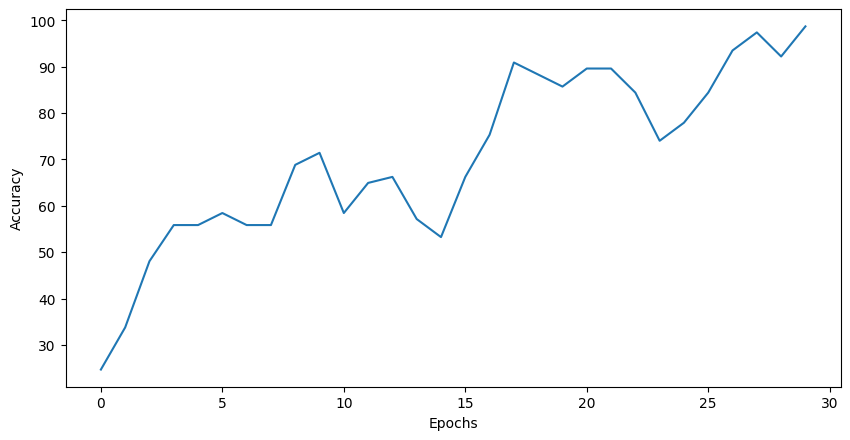

In [11]:
with torch.no_grad():
    matplotlib.rcParams.update({'font.size': 10})
    plt.figure(dpi=100,figsize=(10,5))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot([(t.cpu()/77)*100 for t in train_correct])
    plt.show()

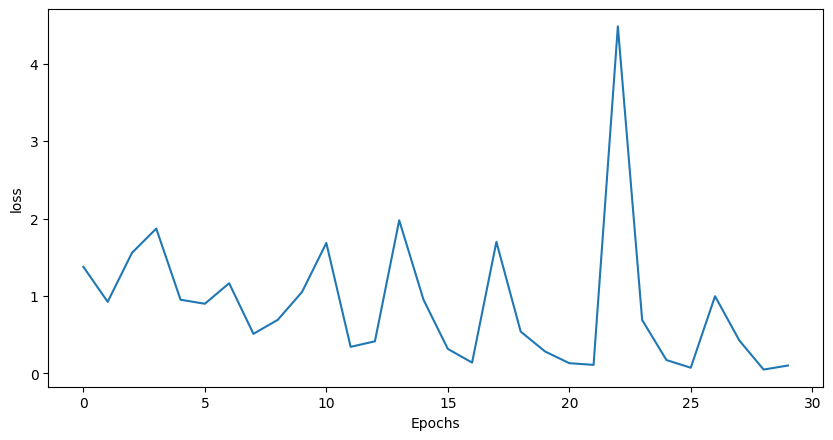

In [12]:
with torch.no_grad():
    matplotlib.rcParams.update({'font.size': 10})
    plt.figure(dpi=100,figsize=(10,5))
    plt.plot([t.cpu() for t in train_losses])
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.show()

In [13]:
torch.save(model.state_dict(),"T1Classification_Adam_CE")

## Validation task

In [14]:
test_set = T1Dataset('./test.csv',root_dir='./exactT1/',transforms=None)
test_loader = DataLoader(test_set,batch_size=1,shuffle=False)


In [1]:
model.load_state_dict(torch.load('./T1Classification_Adam_CE'))
model.eval()
with torch.no_grad():
    correct = 0
    preds =  []
    actual = []
    for img, label in test_loader:
        img,label = img.cuda(),label.cuda()
        y_val = model(img)
        predicted = torch.max(y_val,1)[1]
        
        correct += (predicted == label).sum()
        for i in label:
            actual.append(i.cpu().numpy())
        for i in predicted:
            preds.append(i.cpu().numpy())
print(f'Test accuracy: {correct.item()}/{len(test_loader)} = {correct.item()*100/(len(test_loader)):7.3f}%')

Test accuracy : 17/22 = 77.272%
